# Noise2Void (3D)

In [ ]:
# We import all our dependencies.
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import os
from skimage import io

from tifffile import imread
import stackview
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Dataset

Some example data has been stored at `/projects/p038/p_scads_trainings/BIAS/torch_segmentation_denoising_example_data/denoising_example_data/`. The data can otherwise also be downloaded [here](https://download.fht.org/jug/n2v/flywing-data.zip). Similar to the pytorch dataloader, Noise2Void provides its own `DataGenerator` class, which serves a similar purpose of iterating through the data easily,loading data and extracting patches for training and validation.

In [2]:
root = r'/projects/p038/p_scads_trainings/BIAS/torch_segmentation_denoising_example_data/denoising_example_data/n2v_3d'
filename = 'lund_i000000_oi_000000.tif'

In [3]:
data_generator = N2V_DataGenerator()

We will load all the '.tif' files from the `data` directory. In our case it is only one. The function will return a list of images (numpy arrays). In the `dims` parameter we specify the order of dimensions in the image files we are reading. The `load_imgs_from_directory` function automatically added two extra dimension to the images: One at the front is used to hold a potential stack of images such as a movie. One at the end could hold color channels such as RGB.

In [4]:
imgs = data_generator.load_imgs_from_directory(directory = root, dims='ZYX')
imgs[0].shape

(1, 71, 1024, 512, 1)

Let's look at a maximum projection of the volume. We have to remove the added extra dimensions to display it.

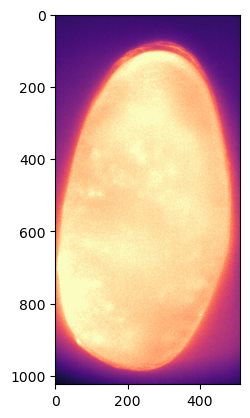

In [5]:
fig, ax = plt.subplots()
ax.imshow(imgs[0].squeeze().max(axis=0), cmap='magma', vmin=np.percentile(imgs[0], 0.1), vmax=np.percentile(imgs[0], 99.9))

## Config

We have to provide a few settings for the training, such as the shape of patches to be extracted from the image. This is necessary, as pushing the whole image data to the device (even on an HPC) would probably use up all available memory at hand. Notice the changed shape along the first axis (the batch dimension).

In [6]:
# Here we extract patches for training and validation.
patch_shape = (32, 64, 64)
patches = data_generator.generate_patches_from_list(imgs[:1], shape=patch_shape)

Generated patches: (2048, 32, 64, 64, 1)


Patches are created so they do not overlap. This is not the case if you specify a number of patches. See the docstring for details! Non-overlapping patches enable us to split them into a training and validation set.

In [7]:
X = patches[:600]
X_val = patches[600:]

Text(0.5, 1.0, 'Validation Patch')

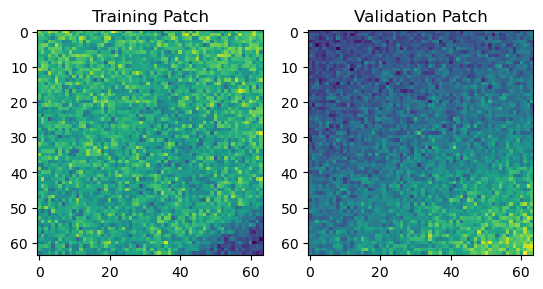

In [8]:
fig, axes = plt.subplots(ncols=2)
axes[0].imshow(X[0,16].squeeze())
axes[0].set_title('Training Patch')
axes[1].imshow(X_val[0,16].squeeze())
axes[1].set_title('Validation Patch')


You can increase `train_steps_per_epoch` to get even better results at the price of longer computation.

In [9]:
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128),train_epochs=20, train_loss='mse', batch_norm=True, 
                   train_batch_size=4, n2v_perc_pix=0.198, n2v_patch_shape=(32, 64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

Let's look at the parameters stored in the config-object.

In [10]:
vars(config)

{'means': ['211.3554'],
 'stds': ['43.559948'],
 'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 4,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (32, 64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

## Model creation

In [11]:
# a name used to identify the model
model_name = 'n2v_3D'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config=config, name=model_name, basedir=basedir)

/app/env/lib/python3.9/site-packages/n2v/models/n2v_standard.py:429: UserWarning: output path for model already exists, files may be overwritten: /home/h1/johamuel/Projects/repos/PoL-BioImage-Analysis-TS-GPU-Accelerated-Image-Analysis/docs/70_AI_Segmentation_Denoising/models/n2v_3D
  warnings.warn(
2023-08-25 15:10:05.841469: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 15:10:07.925917: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 35012 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0b:00.0, compute capability: 8.0


In [12]:
history = model.train(X, X_val)

259 blind-spots will be generated per training patch of size (32, 64, 64).


Preparing validation data: 100%|██████████| 1448/1448 [00:00<00:00, 1717.83it/s]


Epoch 1/20


2023-08-25 15:10:14.661980: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-08-25 15:10:17.572895: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-25 15:10:17.574144: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-25 15:10:17.574182: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-08-25 15:10:17.576223: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-25 15:10:17.576324: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-08-25 15:10:20.276396: I tensorflow/stream_executor/cuda/c

4/4 [==============================] - 16s 2s/step - loss: 3.2999 - n2v_mse: 3.2999 - n2v_abs: 1.5008 - val_loss: 1.0786 - val_n2v_mse: 1.0738 - val_n2v_abs: 0.9134 - lr: 4.0000e-04
Epoch 2/20
4/4 [==============================] - 3s 961ms/step - loss: 1.7476 - n2v_mse: 1.7476 - n2v_abs: 1.1515 - val_loss: 0.9133 - val_n2v_mse: 0.9089 - val_n2v_abs: 0.8382 - lr: 4.0000e-04
Epoch 3/20
4/4 [==============================] - 3s 960ms/step - loss: 1.9134 - n2v_mse: 1.9134 - n2v_abs: 1.2011 - val_loss: 0.8190 - val_n2v_mse: 0.8151 - val_n2v_abs: 0.7894 - lr: 4.0000e-04
Epoch 4/20
4/4 [==============================] - 3s 946ms/step - loss: 1.3084 - n2v_mse: 1.3084 - n2v_abs: 1.0001 - val_loss: 0.8296 - val_n2v_mse: 0.8255 - val_n2v_abs: 0.8026 - lr: 4.0000e-04
Epoch 5/20
4/4 [==============================] - 3s 960ms/step - loss: 0.8024 - n2v_mse: 0.8024 - n2v_abs: 0.7470 - val_loss: 0.7955 - val_n2v_mse: 0.7914 - val_n2v_abs: 0.7933 - lr: 4.0000e-04
Epoch 6/20
4/4 [======================

## Inference

In [14]:
# We load the data we want to process.
img = imread(os.path.join(root, filename))

# Here we process the data.
# The 'n_tiles' parameter can be used if images are too big for the GPU memory.
# If we do not provide the 'n_tiles' parameter the system will automatically try to find an appropriate tiling.
pred = model.predict(img, axes='ZYX', n_tiles=(2,4,4))

The input image is of type uint16 and will be casted to float32 for prediction.
1/1 [==============================] - 1s 548ms/step


  3%|▎         | 1/32 [00:00<00:00, 135300.13it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▋         | 2/32 [00:00<00:01, 18.90it/s]    

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 3/32 [00:00<00:01, 18.90it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▎        | 4/32 [00:00<00:02, 13.12it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 5/32 [00:00<00:02, 13.12it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 6/32 [00:00<00:02, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 7/32 [00:00<00:02, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 8/32 [00:00<00:02, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 9/32 [00:00<00:02, 11.44it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 10/32 [00:00<00:02, 10.74it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 11/32 [00:00<00:01, 10.74it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 12/32 [00:01<00:01, 10.86it/s]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 13/32 [00:01<00:01, 10.86it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 14/32 [00:01<00:01, 10.51it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 15/32 [00:01<00:01, 10.51it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 16/32 [00:01<00:01, 10.75it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 17/32 [00:01<00:01, 10.75it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 18/32 [00:01<00:01, 10.20it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 19/32 [00:01<00:01, 10.20it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▎   | 20/32 [00:01<00:01, 10.60it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 21/32 [00:01<00:01, 10.60it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 22/32 [00:02<00:00, 10.50it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 23/32 [00:02<00:00, 10.50it/s]

1/1 [==============================] - 0s 24ms/step


 75%|███████▌  | 24/32 [00:02<00:00, 10.60it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 25/32 [00:02<00:00, 10.60it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████▏ | 26/32 [00:02<00:00, 10.50it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 27/32 [00:02<00:00, 10.50it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 28/32 [00:02<00:00, 10.79it/s]

1/1 [==============================] - 0s 24ms/step


 91%|█████████ | 29/32 [00:02<00:00, 10.79it/s]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 30/32 [00:02<00:00, 10.62it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 31/32 [00:02<00:00, 10.62it/s]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 32/32 [00:03<00:00, 10.66it/s]


Text(0.5, 1.0, 'Prediction')

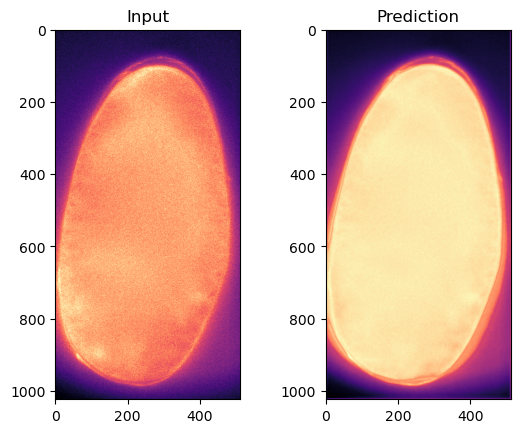

In [15]:
fig, axes = plt.subplots(ncols=2)

axes[0].imshow(img[15], cmap='magma', vmin=np.percentile(img,0.1), vmax=np.percentile(img,99.9))
axes[0].set_title('Input');
axes[1].imshow(pred[15], cmap='magma', vmin=np.percentile(pred,0.1), vmax=np.percentile(pred,99.9))
axes[1].set_title('Prediction')